In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from generation.dataset.data_utils import get_detector_event_df, get_detector_event_signal, get_detector_event_df_path

In [2]:
_DETECTOR = 0
_EVENTS_NUM = 200


detector_signals = np.array([get_detector_event_signal(_DETECTOR, event) 
                    for event in range(_EVENTS_NUM)])

### Data preparation

In [3]:
from sklearn.preprocessing import MinMaxScaler

from generation.dataset.dataset_pytorch import SignalsDataset

In [4]:
def unify_shape(data):
    min_values = np.min(data, axis=1)
    max_values = np.max(data, axis=1)
    data = (data  - min_values[:, None]) / (max_values - min_values)[:, None]
    return data

def transform(data):
    new_data = np.fft.rfft(data)
    norms = np.abs(new_data)
    angles = np.angle(new_data)
    return norms, angles

def inverse(norms, angles):
    return np.real(np.fft.irfft(norms * np.exp(1j * angles)))

class Scaler:
    def __init__(self):
        pass
    
    def scale(self, data):
        self.min_value = np.min(data)
        self.max_value = np.max(data)
        new_data = (data - self.min_value) / (self.max_value - self.min_value)
        return new_data

    def unscale(self, data):
        new_data = data * (self.max_value - self.min_value) + self.min_value
        return new_data


def get_dataset(data):
#     scaler = Scaler()
#     data = scaler.scale(data)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    dataset = SignalsDataset(data)
    return dataset, scaler, data


def test_transform(new_norms, new_angles):
    norms = norms_scaler.unscale(new_norms)
    angles = angles_scaler.unscale(new_angles)
    inverse_noises = inverse(norms, angles)
    assert np.allclose(inverse_noises, origin_noises)


origin_data = detector_signals.copy()
data = unify_shape(origin_data)
data = data[~np.isnan(data).any(axis=1)]
origin_noises = data - np.mean(data, axis=0)
norms, angles = transform(origin_noises)
noises_dataset, noises_scaler, noises = get_dataset(origin_noises)
norms_dataset, norms_scaler, norms = get_dataset(norms)
angles_dataset, angles_scaler, angles = get_dataset(angles)

/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [5]:
fft_noises = np.fft.rfft(noises)
real_noises = np.real(fft_noises)
img_noises = np.imag(fft_noises)

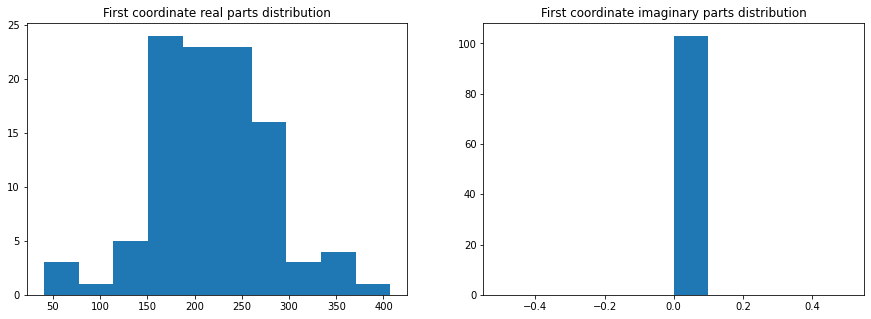

In [6]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title("First coordinate real parts distribution")
ax[0].hist(real_noises[:, 0])
ax[1].set_title("First coordinate imaginary parts distribution")
ax[1].hist(img_noises[:, 0])
plt.show()

##### We do not have to use the first coordinate after fft transform, as it responsible only for absolute shift

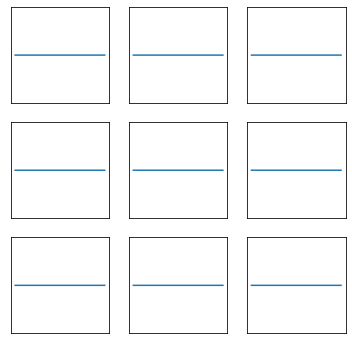

In [7]:
first_real = 0
first_img = 0

f, ax = plt.subplots(3, 3, figsize=(6, 6))

for i in range(9):
    idx = np.random.choice(range(len(noises)))
    new_real = np.concatenate([[first_real], real_noises[idx][1:]])
    new_img = np.concatenate([[first_img], img_noises[idx][1:]])
    new_signal = np.real(np.fft.irfft(new_real + (1j * new_img)))
    ax[i // 3][i % 3].set_xticks([])
    ax[i // 3][i % 3].set_yticks([])
    ax[i // 3][i % 3].plot(np.round(new_signal - noises[idx], 5))
plt.show()

In [8]:
real_noises = real_noises[:, 1:]
img_noises = img_noises[:, 1:]

### Scatter plots after fourier transform

In [9]:
def plot_scatter():
    f, ax = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(9):
        idx = np.random.choice(range(len(fft_noises)))
        ax[i // 3][i % 3].scatter(real_noises[idx], img_noises[idx])

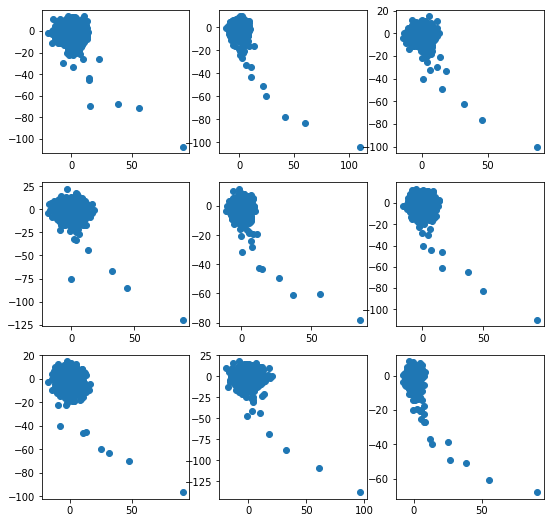

In [10]:
plot_scatter()

#### Scaling

In [11]:
real_scaler = MinMaxScaler()
img_scaler = MinMaxScaler()

real_noises = real_scaler.fit_transform(real_noises)
img_noises = img_scaler.fit_transform(img_noises)

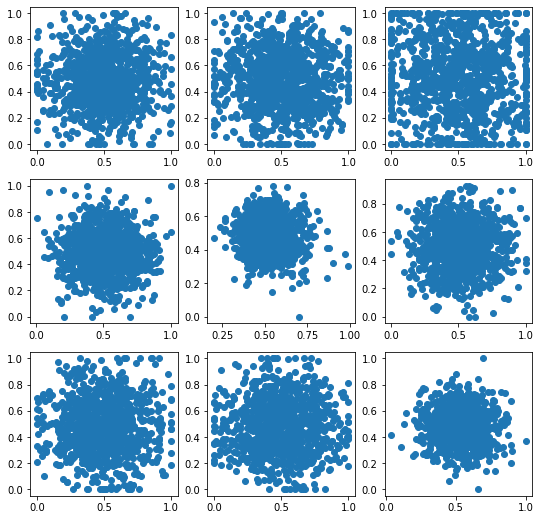

In [12]:
plot_scatter()